In progress(or idea?)

https://github.com/liyu10000/DeepLDA/tree/master

https://github.com/CPJKU/deep_lda/tree/master/deeplda

CNN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)



100%|██████████| 170498071/170498071 [00:10<00:00, 15538993.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [41]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:

# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:

# Train the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 2000}')
            running_loss = 0.0

print('Finished Training')


Finished Training


In [5]:

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')


Accuracy of the network on the 10000 test images: 73.87%


CNN WITHOUT 1 LINEAR

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # No last linear layer

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        return x


In [7]:
# Initialize the model, loss function, and optimizer
model = CNN().to(device)

# Train the model
features_list = []
labels_list = []
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        features_list.append(outputs.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Concatenate the features and labels lists
features = torch.tensor(features_list).squeeze()
labels = torch.tensor(labels_list).squeeze()

# Reshape the features to fit SVM
features = features.view(features.shape[0], -1)

# Only select a subset of labels corresponding to the subset of features
subset_labels = torch.tensor([]).to(device)
for data in trainloader:
    labels = data[1].to(device)
    subset_labels = torch.cat((subset_labels, labels), dim=0)
    if subset_labels.shape[0] >= features.shape[0]:
        break

In [8]:
features.shape

torch.Size([12500, 2048])

In [9]:
subset_labels.shape

torch.Size([12500])

In [10]:
from sklearn.model_selection import train_test_split

# Split features and subset labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.cpu().numpy(), subset_labels.cpu().numpy(), test_size=0.2, random_state=42)

# Print the shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (10000, 2048)
X_test shape: (2500, 2048)
y_train shape: (10000,)
y_test shape: (2500,)


CNN - NO LINEAR

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        return x


In [12]:
# Initialize the model, loss function, and optimizer
model = CNN().to(device)

# Train the model
features_list = []
labels_list = []
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        features_list.append(outputs.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Concatenate the features and labels lists
features = torch.tensor(features_list).squeeze()
labels = torch.tensor(labels_list).squeeze()

# Reshape the features to fit SVM
features = features.view(features.shape[0], -1)

# Only select a subset of labels corresponding to the subset of features
subset_labels = torch.tensor([]).to(device)
for data in trainloader:
    labels = data[1].to(device)
    subset_labels = torch.cat((subset_labels, labels), dim=0)
    if subset_labels.shape[0] >= features.shape[0]:
        break

In [13]:
features.shape

torch.Size([12500, 8192])

In [14]:
subset_labels.shape

torch.Size([12500])

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split features and subset_labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.cpu().numpy(), subset_labels.cpu().numpy(), test_size=0.2, random_state=42)

# Apply Fisher's LDA separately for train and test sets
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)


In [20]:
pred = lda.predict(X_test)

In [21]:

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

Accuracy: 0.1004


In [ ]:
X_train.shape

In [ ]:
X_train_lda.shape

In [ ]:

# Train SVM Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_lda, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test_lda)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.0948


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.09893333333333333


BINARY CLASS

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [39]:
import numpy as np

# Define classes for cat and dog
cat_class = 3  # Index of the class "cat" in CIFAR-10
dog_class = 5  # Index of the class "dog" in CIFAR-10

# Create binary classification dataset with only cat and dog classes
binary_trainset_data = []
binary_trainset_labels = []

binary_testset_data = []
binary_testset_labels = []

# Filter trainset for cat and dog classes
for data, label in trainset:
    if label == cat_class or label == dog_class:
        binary_trainset_data.append(data.numpy())
        binary_trainset_labels.append(label)

# Filter testset for cat and dog classes
for data, label in testset:
    if label == cat_class or label == dog_class:
        binary_testset_data.append(data.numpy())
        binary_testset_labels.append(label)

# Convert lists to numpy arrays
binary_trainset_data = np.array(binary_trainset_data)
binary_trainset_labels = np.array(binary_trainset_labels)

binary_testset_data = np.array(binary_testset_data)
binary_testset_labels = np.array(binary_testset_labels)

# Print the shapes of the binary classification datasets
print("Binary Trainset Data Shape:", binary_trainset_data.shape)
print("Binary Trainset Labels Shape:", binary_trainset_labels.shape)
print("Binary Testset Data Shape:", binary_testset_data.shape)
print("Binary Testset Labels Shape:", binary_testset_labels.shape)


Binary Trainset Data Shape: (10000, 3, 32, 32)
Binary Trainset Labels Shape: (10000,)
Binary Testset Data Shape: (2000, 3, 32, 32)
Binary Testset Labels Shape: (2000,)


In [40]:
# Assuming you have your custom binary dataset with two classes: class 0 and class 1
# Replace binary_trainset_data, binary_trainset_labels, binary_testset_data, and binary_testset_labels with your custom dataset

# Convert the dataset to PyTorch tensors
binary_trainset_data = torch.tensor(binary_trainset_data)
binary_trainset_labels = torch.tensor(binary_trainset_labels)
binary_testset_data = torch.tensor(binary_testset_data)
binary_testset_labels = torch.tensor(binary_testset_labels)


# Create a DataLoader for the binary training and test sets
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(binary_trainset_data, binary_trainset_labels), batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(binary_testset_data, binary_testset_labels), batch_size=1, shuffle=False)

# Now you can use binary_trainloader and binary_testloader for training and testing your binary classification model.


In [18]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # No last linear layer

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        return x


In [19]:
# Initialize lists to store features and labels
features_list = []
labels_list = []
# Initialize the model, loss function, and optimizer
model = CNN().to(device)

# Set model to evaluation mode
model.eval()

# Iterate over the batches in the trainloader
with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass to get the output from the model
        outputs = model(images)

        # Append the outputs and labels to the lists
        features_list.append(outputs.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Concatenate the features and labels lists along the batch dimension
features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

# Convert numpy arrays to tensors
features = torch.tensor(features)
labels = torch.tensor(labels)

# Verify the shape of the features tensor
print("Shape of features tensor:", features.shape)


Shape of features tensor: torch.Size([10000, 512])


In [20]:
labels.shape

torch.Size([10000])

In [21]:
from sklearn.model_selection import train_test_split

# Split features and subset labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.cpu().numpy(), labels.cpu().numpy(), test_size=0.3, random_state=42)

# Print the shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7000, 512)
X_test shape: (3000, 512)
y_train shape: (7000,)
y_test shape: (3000,)


In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split features and subset_labels into train and test sets

# Apply Fisher's LDA separately for train and test sets
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)


In [23]:
X_train_lda.shape

(7000, 1)

In [24]:
X_test.shape

(3000, 512)

In [25]:
pred = lda.predict(X_test)

In [26]:

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

Accuracy: 0.652


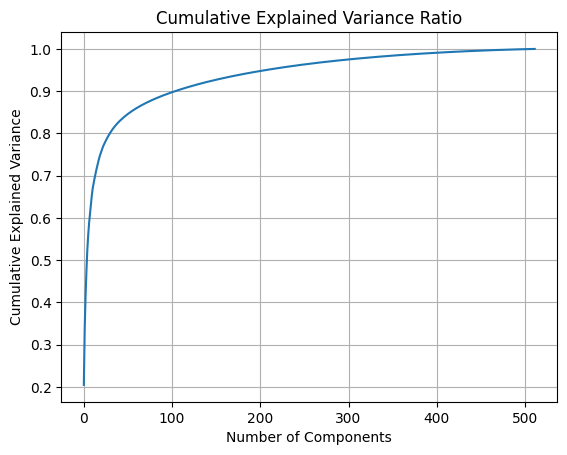

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA()
pca.fit(features)

# Plot explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()


In [28]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=100)  # Choose the number of components you want to keep
features_pca = pca.fit_transform(features)

# Now features_pca contains the transformed features after PCA
print("Shape of features after PCA:", features_pca.shape)


Shape of features after PCA: (10000, 100)


In [29]:
from sklearn.model_selection import train_test_split

# Split features and subset labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels.cpu().numpy(), test_size=0.3, random_state=42)

# Print the shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7000, 100)
X_test shape: (3000, 100)
y_train shape: (7000,)
y_test shape: (3000,)


In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6333333333333333


In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Initialize AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=50)  # You can adjust the number of estimators as needed

# Train the AdaBoost classifier
adaboost_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = adaboost_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6133333333333333


In [32]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting classifier
gradientboost_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)  # You can adjust parameters as needed

# Train the Gradient Boosting classifier
gradientboost_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = gradientboost_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.645


In [33]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Define the pipeline with PCA and LDA
pipeline = Pipeline([
    ('pca', PCA(n_components=100)),  # Apply PCA for dimensionality reduction
    ('lda', LinearDiscriminantAnalysis())  # Apply LDA for further dimensionality reduction and classification
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Transform the data using both PCA and LDA
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6393333333333333


In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier on the transformed data
svm_classifier.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test_transformed)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6396666666666667


In [35]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6333333333333333


OG - NO LDA PCA BINARY

In [42]:

# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:

# Train the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 2000}')
            running_loss = 0.0

print('Finished Training')


[Epoch 1, Batch 2000] Loss: 0.6363511049710214
[Epoch 2, Batch 2000] Loss: 0.5395304089169949
[Epoch 3, Batch 2000] Loss: 0.48299406344071033
[Epoch 4, Batch 2000] Loss: 0.43298426214570646
[Epoch 5, Batch 2000] Loss: 0.3880196993583813
[Epoch 6, Batch 2000] Loss: 0.32783989551718695
[Epoch 7, Batch 2000] Loss: 0.26867921712980025
[Epoch 8, Batch 2000] Loss: 0.20935061232170574
[Epoch 9, Batch 2000] Loss: 0.15758436129702066
[Epoch 10, Batch 2000] Loss: 0.12931390092002729
Finished Training


In [45]:

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')


Accuracy of the network on the test images: 75.15%
